In [1]:
from functools import partial
import numpy as np
import scipy
from scipy.integrate import odeint
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import colors as c
import sympy as sp
import scipy.optimize as op
from matplotlib import image

In [2]:
#Parameters 
b = 10
p = 0.5
a0= 0.01
W0 = 1
q0 = 0.005
zb = 10
hs = 0.1
hf = 0.2
rs = r = 0.5
rf = 0.5
ls = 0.5
lf = 0.2

maxl = 0.05
minl = 0.1
pl =10
zt = 2

In [4]:
#Defining functions

def a(z,zm): #Shading effect
    a = 2*a0 * np.exp(b*(z-zm))/(1+np.exp(b*(z-zm)) )
    return(a)

def q(z):  #Nutrients impact
    q = q0* np.exp(p*z)
    return q

def W(z): #Light attenuation
    W = W0*np.exp(w*z)- W0
    return W

def Ls(z) : #Mortality of submerged 
    res = maxl -(maxl-minl)*zt**pl/(z**pl + zt**pl)
    return res

def Lf(z) : #Mortality of floating 
    res = minl -(minl-maxl)*zt**pl/(z**pl + zt**pl)
    return res

def nm(zm, z,zf, S,F,Sm, Nu0, u):  #Nutrient availability for mutant
    res = Nu2(zm,Nu0, u)/(1 + q(z)*S + q(zm)*Sm + q(zf)*F)
    return res

def n(z,zf, zm, S,F,Sm, Nu0, u):  #Nutrient availability for submerged
    res = Nu2(z, Nu0, u)/(1 + q(z)*S + q(zm)*Sm + q(zf)*F)
    return res

def nf(z,zf, zm, S,F,Sm,Nu0, u):  #Nutrient availability for floating
    res = Nu2(zf, Nu0, u)/(1 + q(z)*S + q(zm)*Sm + q(zf)*F)
    return res

def Nu(z,Nu0, u):  #Nutrient concentration
    nu = (Nu0 / (u* np.sqrt(2*np.pi))) * np.exp(-(zb-z)**2/(u**2))
    return nu

def f(pop,t,z,zf,zm,Nu0,u):  #Main system function (EDO)
    S = pop[0]
    F = pop[1]
    Sm = pop[2]
    f0 =  r*S*n2(z,zf,zm,S,F,Sm, Nu0, u)/(n2(z,zf,zm,S,F,Sm, Nu0, u) +hs)* 1/(1+ a(z,z)*S+a(z,zm)*Sm+ a(z,zf)*F+W(z)) - Ls(z) *S
    f1 =  r*F*nf2(z,zf,zm,S,F,Sm, Nu0, u)/(nf2(z,zf,zm,S,F,Sm, Nu0, u) + hf)* 1/(1+ a(zf,z)*S+a(0,0)*F+W(zf)) - Lf(zf)*F
    f2= r*Sm*nm2(zm,z,zf,S,F,Sm, Nu0, u)/(nm2(zm,z,zf,S,F,Sm, Nu0, u) +hs)* 1/(1+ a(zm,z)*S+a(zm,zm)*Sm+ a(zm,0)*F+W(zm)) - Ls(zm)*Sm
    f = [f0, f1,f2]
    return f


def F2(POP,z, Nu0, u): #Main function 2 (without mutant)
    S = POP[0]
    F = POP[1]
    f0 =  rs*S*ns(z,S,F, Nu0, u)/(ns(z, S,F,Nu0, u) +hs)* 1/(1+ a(z,z)*S+ a(z,0)*F+W(z)) - Ls(z) *S
    f1 =  rf*F*nf1(z,S,F, Nu0, u)/(nf1(z,S,F, Nu0, u) + hf)* 1/(1+  a(0,0)*F+W(0)) - Lf(0) *F
    f = [f0, f1]
    return f

def jacF2(z, S,F, Nu0, u): #Jacobian
    a1 = -rs*Nu(z)*S*( ( hs*q(z)*( 1 + a0*S +a(z,0)*F +W(z)) + a0*(Nu(z)+ hs*(1+ q(0)*F +q(z) *S))) / ((Nu(z)+hs *(1+ q(0)*F +q(z) *S))*(1 + a0*S +a(z,0)*F +W(z)))**2  ) + r*ns(z,S,F, Nu0, u)/(ns(z, S,F,Nu0, u) +hs)* 1/(1+ a(z,z)*S+ a(z,0)*F+W(z)) - Ls(z)
    b1 = -rs*Nu(z)*S*( ( hs*q(0)*( 1 + a0*S +a(z,0)*F +W(z)) + a(z,0)*(Nu(z)+ hs*(1+ q(0)*F +q(z) *S))) / ((Nu(z)+hs *(1+ q(0)*F +q(z) *S))*(1 + a0*S +a(z,0)*F +W(z)))**2  )
    d1 = -rf*Nu(0)*F*( ( hf*q(0)*( 1 + a0*F ) + a0*(Nu(0)+ hf*(1+ q(0)*F +q(z) *S))) / ((Nu(0)+hf *(1+ q(0)*F +q(z) *S))*(1 + a0*F +W(0)))**2  ) + r*nf1(z,S,F, Nu0, u)/(nf1(z,S,F, Nu0, u) + hf)* 1/(1+  a(0,0)*F+W(0)) - Lf(0)
    c1 = -rf*Nu(0)*F*( ( hf*q(z)*( 1 + a0*F ) ) / ((Nu(0)+hf *(1+ q(0)*F +q(z) *S))*(1 + a0*F +W(0)))**2  )
    
    jac = np.array([[a1,b1], [c1,d1]])
     
    return jac 

In [ ]:
#Ranges of parameters study
Nu_val = np.linspace(0.5,100,100)
u_val = np.linspace(0.1,10,300)
zm_val = np.linspace(0,zb,300)
time = np.linspace(0, 8000, 100)

In [28]:
#Defining parameters choice of ecological study
Nu0=10
b = 10
w=0.1
zm=5
N = 300

In [29]:
#Ecological steady states 
popF = np.eye(N) 
popS = np.eye(N) 

for i in range(N):
    u = u_val[i]
    F= S = 100
    for j in range(N): 
        z= zm_val[j]
        traj = odeint(partial(f, z=z, zm=zm,Nu0 = Nu0, u =u), y0= [S, F, 0], t=time)
        S =  traj[-1,0] 
        F = traj[-1,1]
        popS[j,i] = S
        popF[j,i] = F

In [30]:
#Alternative stable states states 
popF2 = np.eye(N) 
popS2 = np.eye(N) 

for i in range(N):
    u = u_val[i]
    F= S = 100
    for j in range(N): 
        z = zm_val[(N-1)-j]  
        traj = odeint(partial(f2, z=z, zm=zm,Nu0 = Nu0, u =u), y0= [S, F, 0], t=time)
        S =  traj[-1,0]
        F = traj[-1,1]
        popS2[(N-1)-j,i] = S
        popF2[(N-1)-j,i] = F

In [31]:
#Determining type of ecological equilibrium (coexistence, only S ...)
coex = np.eye(N)
for i in range(N):
    for j in range(N): 
            if popF[i,j] > 1:
                if popS[i,j] > 1:
                    coex[i,j] =4 
                else:
                    coex[i,j] = 1
            else:
                if popS[i,j] > 1:
                    coex[i,j] = 2
                else:
                    coex[i,j] = 0

In [32]:
#Determining type of bistability 
for i in range(N):
    for j in range(N): 
            if (popF[i,j] > 1 and popS[i,j] < 1 and popS2[i,j] > 1 and popF2[i,j] > 1) or (popF2[i,j] > 1 and popS2[i,j] < 1 and popS[i,j] > 1 and popF[i,j] > 1) : 
                coex[i,j] = 5
            elif (popF[i,j] > 1 and popS[i,j] < 1 and popS2[i,j] > 1 and popF2[i,j] < 1) or  (popF2[i,j] > 1 and popS2[i,j] < 1 and popS[i,j] > 1 and popF[i,j] < 1) : 
                coex[i,j] = 3

In [34]:
import matplotlib.patches as mpatches
#Bifurcation diagram

plt.figure(figsize=(8,5))
im = plt.imshow(coex,cmap='tab20',extent =[0, 10, 10,0],aspect='auto')
values = np.unique(coex.ravel())
colors = [ im.cmap(im.norm(value)) for value in values]
labels = ['I:Unfeasible', 'II:Only floating plants (F)', 'III:Only submerged macrophytes (S)','IV:Bistability Only S/Only F', 'V:Coexistence', 'VI:Bistability coexistence/Only F']
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(values))]
# put those patched as legend-handles into the legend
first_legend= plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )



plt.xlabel('nutrients diffusion (u)')
plt.yticks([0,2,4,6,8,10], ['surface of the lake 0',2,4,6,8,'bottom of the lake 10'], color='black')
plt.ylabel('Submerged plants depth trait (z)')

plt.show()

0.3

In [ ]:
#AD : defining fitness of mutant Sm and fitness gradient 
from scipy.misc import derivative
H = 1e-6

def taux_sm(zm, z, F,S):
    taux = r*nm(zm,z,S,F,0)/(nm(zm,z,S,F,0) +hs)* 1/(1+ a(zm,z)*S+ a(zm,0)*F+W(zm)) - Ls(zm)
    return taux


def GradF(zm,z): #Fitness Gradient 
    j = np.where(u_val >= u)[0][0]
    k = np.where(zm_val >= z)[0][0]
    if popS[i,j] > 1 : 
        S = popS[k,j]
        F = popF[k,j] 
        der = derivative(partial(taux_sm, z=z, F=F, S=S), zm, dx=10e-6)
    else : 
        S = popS2[k,j]
        F = popF2[k,j] 
        der = derivative(partial(taux_sm, z=z, F=F, S=S), zm, dx=10e-6)
            
    return der

In [ ]:
#Second derivatives for type of singular strategies 

def dzdzm(zm,z):
    der = derivative(partial(dz, z=z), zm, dx=10e-6)
    return der

def dzmdzm(zm,z):
    der = (GradF(zm+H,z) - GradF(zm,z))/H
    return der

def dz(zm,z):
    der = (taux_sm(zm,z+H,F,S) - taux_sm(zm,z,F,S))/H
    return der

def dzdz(zm,z):
    der2 = (dz(zm,z+H) - dz(zm,z))/H
    return der2

def dzmdz(zm,z):
    der = (GradF(zm,z+H) - GradF(zm,z))/H
    return der

In [ ]:
#Dichotomy function to determine singular strategies 
def dicho(f, a, b, eps=1e-8):
    if f(a)*f(b) > 0 : 
        return 0  
    else :
        while abs(b-a) > eps:    
            c = (a+b)/2
            if f(a)*f(c) >= 0:
                a=c
            else:
                b=c
        return b 

In [ ]:
#Finding singular strategies(first ones)
singP = np.zeros(N)

for i in range(N):
    u = u_val[i]
    sing = dicho(grad,0.3,10)
    singP[i]= sing

#Finding singular strategies(second ones) 

singP2 = np.zeros(N)

for i in range(int(N/2)):
    u = u_val[i]
    sing = dicho(grad,0,10)
    singP2[i]= sing

    
for i in range(int(N/2),N):
    u = u_val[i]
    sing = dicho(grad,0,1)
    singP2[i]= sing
  

In [ ]:
#Type of singular strategies 
stra= np.zeros(N)
for n in range(N) : 
    u = u_val[n]
    z = singP[n] 
    ess = dzmdzm(z, z)
    css  = dzmdz(z,z)
    if ess < 0 : 
        if css <0 : 
            stra[n] = 4
        else : 
            stra[n] = 1
    elif css < 0 : 
        stra[n] = 3
        
stra2= np.zeros(N)
for n in range(N) : 
    u = u_val[n]
    z = singP2[n] 
    ess = dzmdzm(z, z)
    css  = dzmdz(z,z)
    if ess < 0 : 
        if css <0 : 
            stra2[n] = 4
        else : 
            stra2[n] = 1
    elif css < 0 : 
        stra2[n] = 3

In [38]:
#Regrouping singular strategies (CSS, BP ..)
u_blanc = u_val[np.where(stra == 4)]
sing_blanc = singP[np.where(stra == 4)]

u_red = u_val[np.where(stra== 3)]
sing_red = singP[np.where(stra == 3)]

u_black = u_val[np.where(stra2 == 0)]
sing_black = singP2[np.where(stra2 == 0)]

In [45]:
#Import final mean traits and range of traits from structured pop model
trait_min= np.genfromtxt(fname='trait min w=0.1 hill')
trait_max= np.genfromtxt(fname='trait max w=0.1 hill')
trait_mean = np.genfromtxt(fname='trait mean w=0.1 hill')

In [23]:
trait_mincoevo= np.genfromtxt(fname='trait min coevo w=0.1 hill')
trait_maxcoevo= np.genfromtxt(fname='trait max coevo w=0.1 hill')
trait_meancoevo = np.genfromtxt(fname='trait mean coevo w=0.1 hill')

NameError: name 'uval2' is not defined

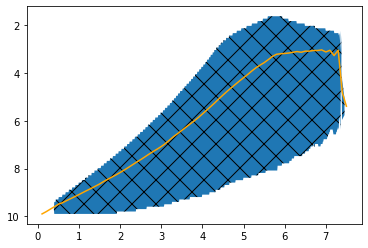

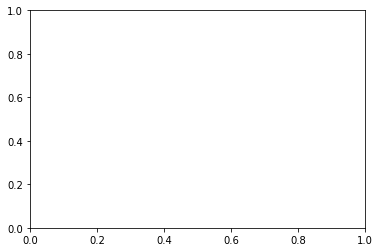

In [45]:
fig1, ax = plt.subplots(1,1)
ax.plot(np.linspace(0.1,10,100), trait_mean, c='orange')
ax.fill_between(np.linspace(0.1,10,1000)[np.where(trait_min > 0)], trait_max[np.where(trait_min > 0)], trait_min[np.where(trait_min > 0)],hatch='X')
ax.invert_yaxis()

fig2, ax2 = plt.subplots(1,1)
ax2.plot(uval2, meancoevo, c='g')
ax2.fill_between(uval2, maxcoevo,mincoevo, color='palegoldenrod')
ax2.invert_yaxis()

In [18]:
maxcoevo = np.append(trait_maxcoevo[np.where(trait_mincoevo > 0)],6.36)

In [19]:
uval2 = np.append(uval2 , 7.5)

In [20]:
meancoevo = np.append(meancoevo,3.2)
mincoevo = np.append(mincoevo,2.4)
maxcoevo = np.append(maxcoevo,6)

Text(0, 0.5, 'S pop size')

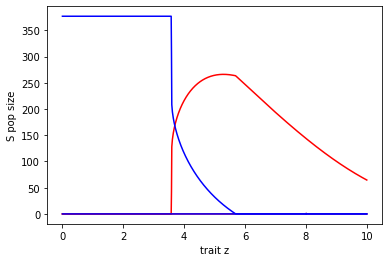

In [123]:
i = 800
plt.plot(zm_val, popS[:,i], 'r')
plt.plot(zm_val, popS2[:,i],'r')

plt.plot(zm_val, popF[:,i], 'b')
plt.plot(zm_val, popF2[:,i],'b')


plt.xlabel('trait z')
plt.ylabel('S pop size')

In [ ]:
np.savetxt('colors.txt',colors)

In [353]:
finalpopS = np.zeros(100)
finalpopF = np.zeros(100)
for i in range(100) : 
    z = singP[i] 
    k = int(z*10)
    finalpopS[i] = popS[k,i]
    finalpopF[i] = popF[k,i]

In [74]:

popFpde =np.genfromtxt(fname='pop F PDE w=0.1 hill')

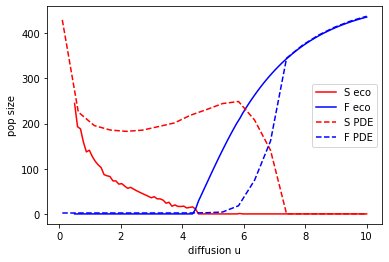

In [355]:
plt.plot(u_val, finalpopS, c='r',label='S eco' )
plt.plot(u_val, finalpopF, c='b',label='F eco' )
plt.plot(uval2, popSpde, 'r--', label='S PDE')
plt.plot(uval2, popFpde, 'b--', label='F PDE')
plt.xlabel('diffusion u')
plt.ylabel('pop size')
plt.legend()

In [14]:
trait_mean = np.genfromtxt(fname='trait mean w=0.1 hill')
trait_std = np.genfromtxt(fname='trait std w=0.1 hill')

In [10]:
coex=  np.genfromtxt(fname='w=0.2Ls hill.txt')
popS2 = np.genfromtxt(fname='popS2 w=0.2Ls hill.txt')
popS = np.genfromtxt(fname='popS w=0.2Ls hill.txt')
popF2 = np.genfromtxt(fname='popF2 w=0.2Ls hill.txt')
popF = np.genfromtxt(fname='popF w=0.2Ls hill.txt')

In [45]:
np.savetxt('w='+ valw + 'Ls hill.txt', coex)
np.savetxt('popS2 w='+ valw + 'Ls hill.txt', popS2)
np.savetxt('popS w='+ valw + 'Ls hill.txt', popS)
np.savetxt('popF2 w='+ valw + 'Ls hill.txt', popF2)
np.savetxt('popF w='+ valw + 'Ls hill.txt', popF)